# CSIRO Biomass Lightning Pipeline

This notebook walks through the whole project one small step at a time. Every step has a short note in simple words so anyone can follow along, even without machine-learning experience.



## Step 0 · Environment Prep

Here we grab the tools the rest of the notebook needs. Think of it as packing a toolbox: we make sure the right computer libraries are installed, imported, and that the computer knows whether to use the graphics card or the normal processor. We also fix the random seeds so we get the same results each time.



In [1]:
# Install core dependencies (uncomment on Kaggle if needed)
# !pip install -q pytorch-lightning torchmetrics timm

import os
import random
from pathlib import Path
from typing import Optional, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm.auto import tqdm

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as T

import timm
import pytorch_lightning as pl
from pytorch_lightning.loggers import CSVLogger
import torchmetrics
from torchmetrics import MeanAbsoluteError, MeanSquaredError

print(f"pytorch_lightning: {pl.__version__}")
print(f"torch: {torch.__version__}")
print(f"torchvision: {torchvision.__version__}")
print(f"timm: {timm.__version__}")
print(f"torchmetrics: {torchmetrics.__version__}")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

np.random.seed(42)
random.seed(42)
pl.seed_everything(42, workers=True)



/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

pytorch_lightning: 2.5.5
torch: 2.6.0+cu124
torchvision: 0.21.0+cu124
timm: 1.0.19
torchmetrics: 1.8.2
Device: cuda


42

## Step 1 · Load and Inspect Data

In this step we open the spreadsheet-style files that hold the training and test information. We peek at how many rows there are, what the targets look like, and we add an extra column that turns the sampling dates into day-of-year numbers. This is the “getting to know the data” part.



In [2]:
DATA_ROOT_CANDIDATES = [
    Path('/kaggle/input/csiro-biomass'),
    Path('/Users/ryan/Code/csiro/dataset')
]
PATH_DATA = next((p for p in DATA_ROOT_CANDIDATES if p.exists()), DATA_ROOT_CANDIDATES[-1])
print(f"Using data at: {PATH_DATA}")

train_csv = PATH_DATA / 'train.csv'
test_csv = PATH_DATA / 'test.csv'

train_df = pd.read_csv(train_csv)
test_df = pd.read_csv(test_csv)
print(f"Train rows: {len(train_df):,}")
print(f"Test rows: {len(test_df):,}")
print(f"Targets: {sorted(train_df['target_name'].unique())}")

train_df['Sampling_Date'] = pd.to_datetime(train_df['Sampling_Date'])
train_df['Day_of_Year'] = train_df['Sampling_Date'].dt.dayofyear
TARGET_COLS = ['target']

train_df['absolute_image_path'] = train_df['image_path'].apply(lambda p: str(PATH_DATA / p))

train_df.head()



Using data at: /kaggle/input/csiro-biomass
Train rows: 1,785
Test rows: 5
Targets: ['Dry_Clover_g', 'Dry_Dead_g', 'Dry_Green_g', 'Dry_Total_g', 'GDM_g']


,sample_id,image_path,Sampling_Date,State,Species,Pre_GSHH_NDVI,Height_Ave_cm,target_name,target,Day_of_Year,absolute_image_path
0,ID1011485656__Dry_Clover_g,train/ID1011485656.jpg,2015-09-04,Tas,Ryegrass_Clover,0.62,4.6667,Dry_Clover_g,0.0000,247,/kaggle/input/csiro-biomass/train/ID1011485656...
1,ID1011485656__Dry_Dead_g,train/ID1011485656.jpg,2015-09-04,Tas,Ryegrass_Clover,0.62,4.6667,Dry_Dead_g,31.9984,247,/kaggle/input/csiro-biomass/train/ID1011485656...
2,ID1011485656__Dry_Green_g,train/ID1011485656.jpg,2015-09-04,Tas,Ryegrass_Clover,0.62,4.6667,Dry_Green_g,16.2751,247,/kaggle/input/csiro-biomass/train/ID1011485656...
3,ID1011485656__Dry_Total_g,train/ID1011485656.jpg,2015-09-04,Tas,Ryegrass_Clover,0.62,4.6667,Dry_Total_g,48.2735,247,/kaggle/input/csiro-biomass/train/ID1011485656...
4,ID1011485656__GDM_g,train/ID1011485656.jpg,2015-09-04,Tas,Ryegrass_Clover,0.62,4.6667,GDM_g,16.2750,247,/kaggle/input/csiro-biomass/train/ID1011485656...


Here we draw simple charts so we can see how the numbers and categories behave. Histograms show how values are spread out, and pie charts show how often each label appears. We also check if the day of the year has any pattern with the target.



/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


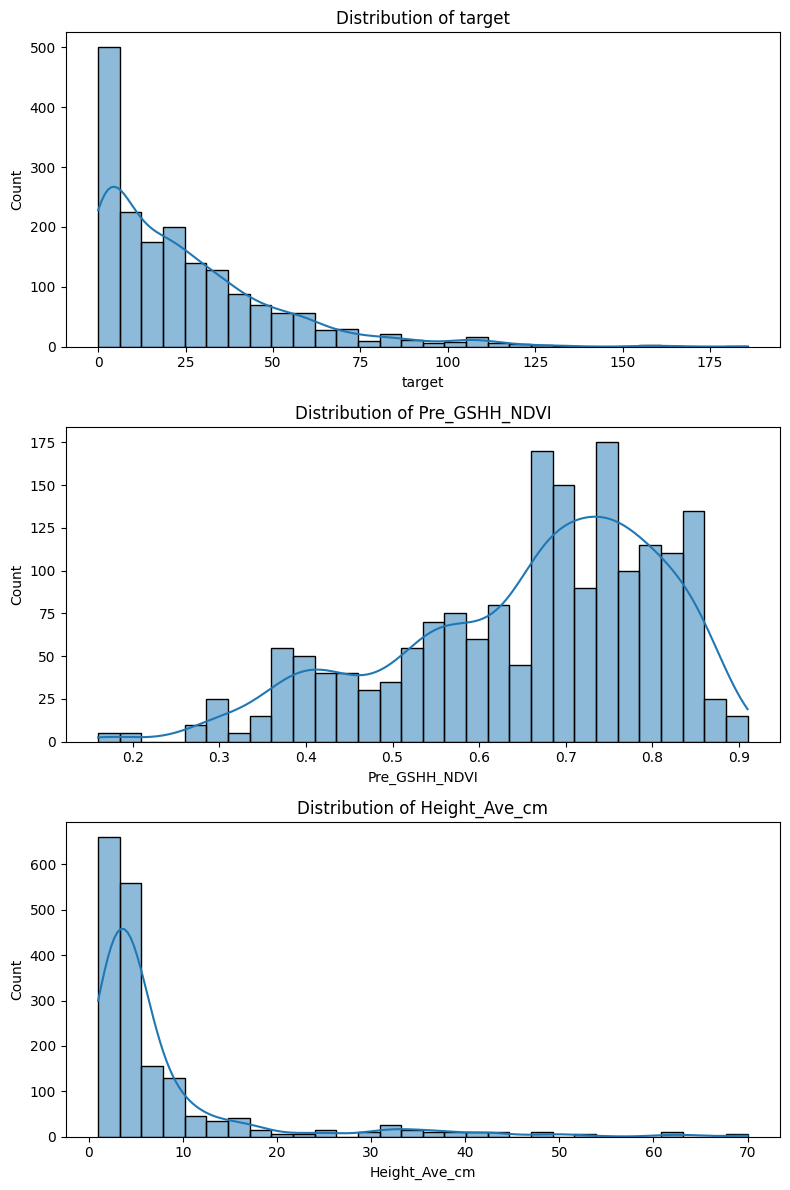

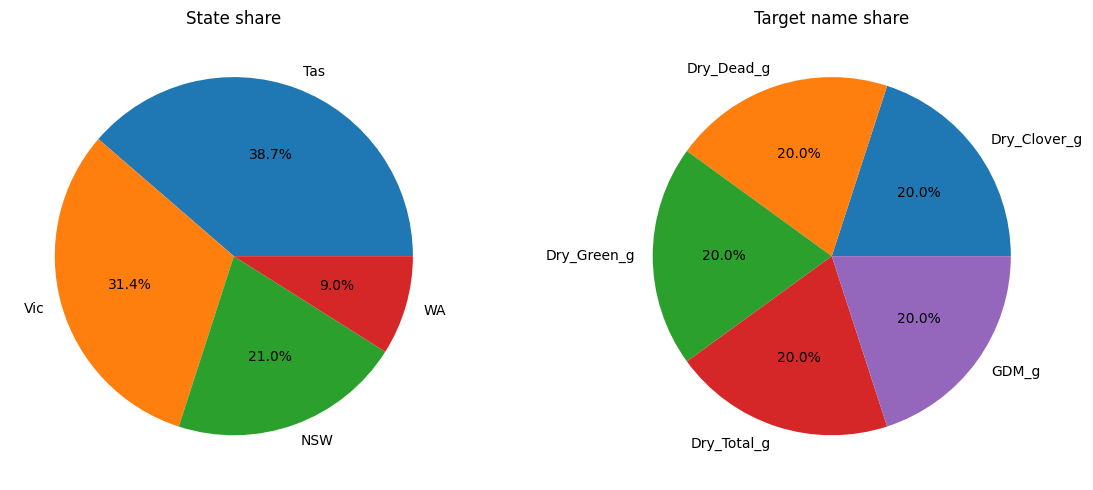

Correlation between Day_of_Year and target: -0.101


In [3]:
numeric_cols = ['target', 'Pre_GSHH_NDVI', 'Height_Ave_cm']
fig, axes = plt.subplots(len(numeric_cols), 1, figsize=(8, 12))
for idx, col in enumerate(numeric_cols):
    sns.histplot(train_df[col], ax=axes[idx], bins=30, kde=True)
    axes[idx].set_title(f"Distribution of {col}")
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
train_df['State'].value_counts().plot.pie(ax=axes[0], autopct='%1.1f%%')
axes[0].set_ylabel('')
axes[0].set_title('State share')
train_df['target_name'].value_counts().plot.pie(ax=axes[1], autopct='%1.1f%%')
axes[1].set_ylabel('')
axes[1].set_title('Target name share')
plt.tight_layout()
plt.show()

corr = train_df.groupby('image_path')[['Day_of_Year', 'target']].mean().corr().loc['Day_of_Year', 'target']
print(f"Correlation between Day_of_Year and target: {corr:.3f}")



These helper functions make it easy to view example photos and measure their sizes. The first one shows a small gallery of images with their target numbers, and the second one checks how wide and tall the images are so we know what shapes we are dealing with.



In [4]:
def show_images(df: pd.DataFrame, n: int = 12, by: str = 'target') -> None:
    sample = df.sort_values(by).head(n)
    cols = 4
    rows = int(np.ceil(len(sample) / cols))
    plt.figure(figsize=(4 * cols, 4 * rows))
    for idx, (_, row) in enumerate(sample.iterrows(), start=1):
        try:
            image = Image.open(row['absolute_image_path']).convert('RGB')
        except FileNotFoundError:
            print(f"Missing file: {row['absolute_image_path']}")
            continue
        plt.subplot(rows, cols, idx)
        plt.imshow(image)
        plt.axis('off')
        plt.title(f"{row['target_name']}\n{row['target']:.1f}")
    plt.tight_layout()
    plt.show()


def analyse_image_dimensions(df: pd.DataFrame) -> pd.DataFrame:
    stats = []
    for path in tqdm(df['absolute_image_path'].unique(), desc='Scanning image sizes'):
        try:
            with Image.open(path) as img:
                stats.append({'width': img.width, 'height': img.height})
        except FileNotFoundError:
            continue
    dims = pd.DataFrame(stats)
    if not dims.empty:
        sns.jointplot(data=dims, x='width', y='height', kind='hex')
        plt.suptitle('Image dimension spread', y=1.02)
        plt.show()
    return dims



This cell is optional. If you run it, you will actually see the sample images and the size report from the helpers above. Skip it if you are on a machine that cannot show pictures.



In [5]:
# Uncomment to view a few samples and inspect image dimensions
# show_images(train_df, n=8)
# dimension_stats = analyse_image_dimensions(train_df)



## Step 2 · Dataset with Two Halves

Here we build a custom dataset class. Each original photo is split down the middle into a left half and a right half, effectively doubling how many training samples we have. The class also loads the targets so that every crop keeps the right label.



In [6]:
class BiomassDataset(Dataset):
    def __init__(
        self,
        df: pd.DataFrame,
        image_root: Path,
        transforms: Optional[torch.nn.Module] = None,
        mode: str = 'train',
        target_column: str = 'target'
    ):
        self.df = df.reset_index(drop=True).copy()
        self.image_root = Path(image_root)
        self.transforms = transforms
        self.mode = mode
        self.target_column = target_column
        self._len = len(self.df) * 2

    def __len__(self) -> int:
        return self._len

    def _load_image(self, image_path: str) -> Image.Image:
        full_path = image_path
        if not Path(full_path).is_absolute():
            full_path = self.image_root / image_path
        with Image.open(full_path) as img:
            return img.convert('RGB')

    def __getitem__(self, idx: int):
        row_idx = idx // 2
        crop_side = idx % 2
        row = self.df.iloc[row_idx]
        image = self._load_image(row.get('absolute_image_path', row['image_path']))
        width, height = image.size
        midpoint = width // 2
        if crop_side == 0:
            crop = image.crop((0, 0, midpoint, height))
        else:
            crop = image.crop((midpoint, 0, width, height))
        if self.transforms:
            crop = self.transforms(crop)
        if self.mode == 'test':
            return crop, row['image_path']
        target = torch.tensor(row[self.target_column], dtype=torch.float32)
        return crop, target



## Step 3 · LightningDataModule Setup

This section wires everything into a neat data pipeline. It decides how big each batch is, which random image tweaks we apply during training, and how to split the data into training and validation groups. It also prepares the test images so we can later make predictions on them.



In [7]:
class BiomassDataModule(pl.LightningDataModule):
    def __init__(
        self,
        data_path: Path,
        batch_size: int = 32,
        img_size: Tuple[int, int] = (456, 456),
        val_split: float = 0.2,
        num_workers: Optional[int] = None
    ):
        super().__init__()
        self.data_path = Path(data_path)
        self.batch_size = batch_size
        self.img_size = img_size
        self.val_split = val_split
        self.num_workers = num_workers or min(os.cpu_count() or 4, 16)

        self.train_transforms = T.Compose([
            T.RandomResizedCrop(self.img_size),
            T.RandomHorizontalFlip(),
            T.RandomVerticalFlip(),
            T.ColorJitter(0.1, 0.1, 0.1, 0.1),
            T.RandomAffine(15, translate=(0.1, 0.1), scale=(0.9, 1.1)),
            T.GaussianBlur(3),
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

        self.eval_transforms = T.Compose([
            T.CenterCrop(self.img_size),
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

        self.train_df = None
        self.val_df = None
        self.test_df = None

    def setup(self, stage: Optional[str] = None) -> None:
        if stage in (None, 'fit'):
            df = pd.read_csv(self.data_path / 'train.csv')
            df['Sampling_Date'] = pd.to_datetime(df['Sampling_Date'])
            df['Day_of_Year'] = df['Sampling_Date'].dt.dayofyear
            df['absolute_image_path'] = (self.data_path / df['image_path']).astype(str)
            df = df.sample(frac=1.0, random_state=42).reset_index(drop=True)
            val_size = int(len(df) * self.val_split)
            self.train_df = df.iloc[val_size:].reset_index(drop=True)
            self.val_df = df.iloc[:val_size].reset_index(drop=True)

        if stage in (None, 'test', 'predict'):
            test_df = pd.read_csv(self.data_path / 'test.csv')
            test_df['absolute_image_path'] = (self.data_path / test_df['image_path']).astype(str)
            self.test_df = test_df.reset_index(drop=True)

    def train_dataloader(self) -> DataLoader:
        dataset = BiomassDataset(
            df=self.train_df,
            image_root=self.data_path,
            transforms=self.train_transforms,
            mode='train'
        )
        return DataLoader(
            dataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=True,
            pin_memory=True,
            persistent_workers=self.num_workers > 0
        )

    def val_dataloader(self) -> DataLoader:
        dataset = BiomassDataset(
            df=self.val_df,
            image_root=self.data_path,
            transforms=self.eval_transforms,
            mode='train'
        )
        return DataLoader(
            dataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=False,
            pin_memory=True,
            persistent_workers=self.num_workers > 0
        )

    def test_dataloader(self) -> DataLoader:
        dataset = BiomassDataset(
            df=self.test_df,
            image_root=self.data_path,
            transforms=self.eval_transforms,
            mode='test'
        )
        return DataLoader(
            dataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=False,
            pin_memory=True,
            persistent_workers=self.num_workers > 0
        )

    def predict_dataloader(self) -> DataLoader:
        return self.test_dataloader()



## Step 4 · Batch Sanity Checks

Before training, we take a quick look at one batch coming out of the data pipeline. We confirm that the number of images and targets matches, and we offer an optional visual check so we can see the crops after the random tweaks. It is a friendly “trust but verify” step.



In [8]:
data_module = BiomassDataModule(
    data_path=PATH_DATA,
    batch_size=8,
    img_size=(528, 528)
)
data_module.setup('fit')
train_loader = data_module.train_dataloader()
val_loader = data_module.val_dataloader()
print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")

batch_images, batch_targets = next(iter(train_loader))
print(f"Batch image shape: {batch_images.shape}")
print(f"Batch target shape: {batch_targets.shape}")

def denormalize(tensor: torch.Tensor) -> torch.Tensor:
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    return tensor * std + mean

# Uncomment to visualise a few crops after augmentation
# grid = torchvision.utils.make_grid(denormalize(batch_images[:6]))
# plt.figure(figsize=(10, 5))
# plt.imshow(grid.permute(1, 2, 0).numpy())
# plt.axis('off')
# plt.show()



Train batches: 357
Val batches: 90
Batch image shape: torch.Size([8, 3, 528, 528])
Batch target shape: torch.Size([8])


## Step 5 · LightningModel Definition

Now we build the actual brain of the project. We start from a well-known image model (EfficientNet) and add a small layer that predicts a single number. We also define how the model measures its own mistakes using a blend of two common loss functions, and we track error metrics that are easy to understand.



In [9]:
class BiomassRegressionModel(pl.LightningModule):
    def __init__(
        self,
        model_name: str = 'tf_efficientnetv2_m',
        pretrained: bool = True,
        num_targets: int = 1,
        learning_rate: float = 0.01,
        loss_weight_smooth_l1: float = 0.5
    ):
        super().__init__()
        self.save_hyperparameters()

        self.backbone = timm.create_model(
            model_name,
            pretrained=pretrained,
            num_classes=0,
            global_pool='avg'
        )
        self.regression_head = nn.Linear(self.backbone.num_features, num_targets)

        self.smooth_l1 = nn.SmoothL1Loss()
        self.mse = nn.MSELoss()
        self.train_mae = MeanAbsoluteError()
        self.train_mse = MeanSquaredError()
        self.val_mae = MeanAbsoluteError()
        self.val_mse = MeanSquaredError()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        features = self.backbone(x)
        return self.regression_head(features)

    def _compute_loss(self, preds: torch.Tensor, targets: torch.Tensor):
        preds = preds.view_as(targets)
        smooth = self.smooth_l1(preds, targets)
        mse = self.mse(preds, targets)
        weight = self.hparams.loss_weight_smooth_l1
        total = weight * smooth + (1 - weight) * mse
        return total, smooth, mse

    def training_step(self, batch, batch_idx):
        images, targets = batch
        preds = self(images).squeeze(-1)
        targets = targets.view_as(preds)
        loss, smooth_loss, mse_loss = self._compute_loss(preds, targets)
        self.train_mae.update(preds, targets)
        self.train_mse.update(preds, targets)
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log('train_smooth_l1', smooth_loss, on_step=True, on_epoch=False)
        self.log('train_mse', mse_loss, on_step=True, on_epoch=False)
        self.log('train_mae', self.train_mae, on_step=True, on_epoch=True, prog_bar=True)
        self.log('train_mse_epoch', self.train_mse, on_step=False, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        images, targets = batch
        preds = self(images).squeeze(-1)
        targets = targets.view_as(preds)
        loss, smooth_loss, mse_loss = self._compute_loss(preds, targets)
        self.val_mae.update(preds, targets)
        self.val_mse.update(preds, targets)
        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log('val_smooth_l1', smooth_loss, on_step=False, on_epoch=True)
        self.log('val_mse', mse_loss, on_step=False, on_epoch=True)
        self.log('val_mae', self.val_mae, on_step=False, on_epoch=True, prog_bar=True)
        self.log('val_mse_epoch', self.val_mse, on_step=False, on_epoch=True)
        return {'val_loss': loss}

    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        images, image_paths = batch
        preds = self(images).squeeze(-1)
        return preds, image_paths

    def configure_optimizers(self):
        optimizer = torch.optim.SGD(
            self.parameters(),
            lr=self.hparams.learning_rate,
            momentum=0.9
        )
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer,
            mode='min',
            factor=0.1,
            patience=3,
            verbose=True,
            monitor='val_loss'
        )
        return {
            'optimizer': optimizer,
            'lr_scheduler': scheduler,
            'monitor': 'val_loss'
        }



## Step 6 · Trainer, Logging, and Saving

This step prepares the training loop. We tell Lightning how many times to pass over the data, what hardware to use, and how often to write down progress. If you press go (uncomment the line), it will train the model and you can optionally save the learned weights to a file.



In [10]:
model = BiomassRegressionModel(
    model_name='tf_efficientnet_b6',
    pretrained=False,
    learning_rate=0.01
)
logger = CSVLogger(save_dir='logs', name='biomass_regression')
trainer = pl.Trainer(
    max_epochs=20,
    accelerator='auto',
    devices='auto',
    precision='16-mixed',
    log_every_n_steps=5,
    logger=logger
)

# Uncomment the next line to train when running on GPU
# trainer.fit(model, data_module)

# Uncomment to save weights after training
# torch.save(model.state_dict(), 'biomass_regression_model.pth')



## Step 7 · Metric Visualisation

After training finishes, Lightning leaves a trail of numbers inside a CSV file. Here we load that file and draw simple line charts so we can see how the loss and error changed over time. It is an easy way to spot whether the model kept improving or got stuck.



In [11]:
metrics_csv_path = Path(logger.log_dir) / 'metrics.csv'
if metrics_csv_path.exists():
    metrics = pd.read_csv(metrics_csv_path)
    metrics = metrics.drop(columns=[col for col in metrics.columns if col.startswith('step')], errors='ignore')
    metrics = metrics.set_index('epoch')
    melted = metrics.reset_index().melt(id_vars='epoch')

    def plot_metric(subset_keys, title):
        subset = melted[melted['variable'].isin(subset_keys)]
        plt.figure(figsize=(8, 5))
        sns.lineplot(data=subset, x='epoch', y='value', hue='variable', marker='o')
        plt.yscale('log')
        plt.title(title)
        plt.tight_layout()
        plt.show()

    plot_metric(['train_loss', 'val_loss'], 'Loss (log scale)')
    plot_metric(['train_mae', 'val_mae'], 'MAE (log scale)')
    plot_metric(['train_mse_epoch', 'val_mse_epoch'], 'MSE (log scale)')
else:
    print(f"Metrics file not found at {metrics_csv_path}. Run training first.")



Metrics file not found at logs/biomass_regression/version_0/metrics.csv. Run training first.


## Step 8 · Test Inference and Submission

Finally we switch the model into evaluation mode and feed it the test images. We collect the predictions, make sure no values go below zero, average the two halves back together, and join everything with the official test list. The result is a ready-to-upload `submission.csv` file.



In [12]:
data_module.setup('test')
test_loader = data_module.test_dataloader()

model.eval()
model.to(device)
all_preds, all_paths = [], []
with torch.no_grad():
    for images, image_paths in tqdm(test_loader, desc='Predicting', total=len(test_loader)):
        images = images.to(device)
        outputs = model(images).squeeze(-1)
        all_preds.extend(outputs.cpu().tolist())
        all_paths.extend(image_paths)

predictions_raw = pd.DataFrame({'image_path': all_paths, 'target': all_preds})
predictions_raw['target'] = predictions_raw['target'].clip(lower=0.0)
prediction_df = predictions_raw.groupby('image_path', as_index=False)['target'].mean()

submission = test_df.merge(prediction_df, on='image_path', how='left')
submission['target'] = submission['target'].fillna(0.0)
submission[['sample_id', 'target']].to_csv('submission.csv', index=False)
print(submission.head())
print('Saved submission.csv')



Predicting:   0%|          | 0/2 [00:00<?, ?it/s]

                    sample_id             image_path   target_name  target
0  ID1001187975__Dry_Clover_g  test/ID1001187975.jpg  Dry_Clover_g     0.0
1    ID1001187975__Dry_Dead_g  test/ID1001187975.jpg    Dry_Dead_g     0.0
2   ID1001187975__Dry_Green_g  test/ID1001187975.jpg   Dry_Green_g     0.0
3   ID1001187975__Dry_Total_g  test/ID1001187975.jpg   Dry_Total_g     0.0
4         ID1001187975__GDM_g  test/ID1001187975.jpg         GDM_g     0.0
Saved submission.csv
